(11624.45, -16673.78)
(10245.48, -3993.3)
(31490.16, 3191.93)
(13538.46, -700.32)
(32629.37, 3048.08)
(16426.27, -1243.14)


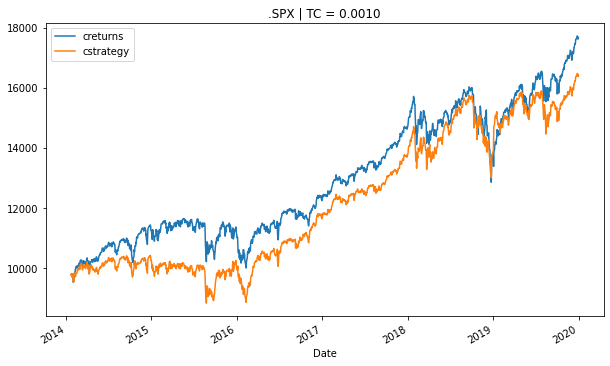

In [2]:
#
# Python Module with Class
# for Vectorized Backtesting
# of Machine Learning-Based Strategies
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
import numpy as np
import pandas as pd
from sklearn import linear_model


class ScikitVectorBacktester(object):
    ''' Class for the vectorized backtesting of
    machine learning-based trading strategies.

    Attributes
    ==========
    symbol: str
        TR RIC (financial instrument) to work with
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: int, float
        amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g., 0.5% = 0.005) per trade
    model: str
        either 'regression' or 'logistic'

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    select_data:
        selects a sub-set of the data
    prepare_features:
        prepares the features data for the model fitting
    fit_model:
        implements the fitting step
    run_strategy:
        runs the backtest for the regression-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def __init__(self, symbol, start, end, amount, tc, model):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        if model == 'regression':
            self.model = linear_model.LinearRegression()
        elif model == 'logistic':
            self.model = linear_model.LogisticRegression(C=1e6,
                solver='lbfgs', multi_class='ovr', max_iter=1000)
        else:
            raise ValueError('Model not known or not yet implemented.')
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['returns'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()

    def select_data(self, start, end):
        ''' Selects sub-sets of the financial data.
        '''
        data = self.data[(self.data.index >= start) &
                         (self.data.index <= end)].copy()
        return data

    def prepare_features(self, start, end):
        ''' Prepares the feature columns for the regression and prediction steps.
        '''
        self.data_subset = self.select_data(start, end)
        self.feature_columns = []
        for lag in range(1, self.lags + 1):
            col = 'lag_{}'.format(lag)
            self.data_subset[col] = self.data_subset['returns'].shift(lag)
            self.feature_columns.append(col)
        self.data_subset.dropna(inplace=True)

    def fit_model(self, start, end):
        ''' Implements the fitting step.
        '''
        self.prepare_features(start, end)
        self.model.fit(self.data_subset[self.feature_columns],
                       np.sign(self.data_subset['returns']))

    def run_strategy(self, start_in, end_in, start_out, end_out, lags=3):
        ''' Backtests the trading strategy.
        '''
        self.lags = lags
        self.fit_model(start_in, end_in)
        # data = self.select_data(start_out, end_out)
        self.prepare_features(start_out, end_out)
        prediction = self.model.predict(
            self.data_subset[self.feature_columns])
        self.data_subset['prediction'] = prediction
        self.data_subset['strategy'] = (self.data_subset['prediction'] *
                                        self.data_subset['returns'])
        # determine when a trade takes place
        trades = self.data_subset['prediction'].diff().fillna(0) != 0
        # subtract transaction costs from return when trade takes place
        self.data_subset['strategy'][trades] -= self.tc
        self.data_subset['creturns'] = (self.amount *
                        self.data_subset['returns'].cumsum().apply(np.exp))
        self.data_subset['cstrategy'] = (self.amount *
                        self.data_subset['strategy'].cumsum().apply(np.exp))
        self.results = self.data_subset
        # absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | TC = %.4f' % (self.symbol, self.tc)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                     figsize=(10, 6))


if __name__ == '__main__':
    scibt = ScikitVectorBacktester('.SPX', '2010-1-1', '2019-12-31',
                                   10000, 0.0, 'regression')
    print(scibt.run_strategy('2010-1-1', '2019-12-31',
                             '2010-1-1', '2019-12-31'))
    print(scibt.run_strategy('2010-1-1', '2016-12-31',
                             '2017-1-1', '2019-12-31'))
    scibt = ScikitVectorBacktester('.SPX', '2010-1-1', '2019-12-31',
                                   10000, 0.0, 'logistic')
    print(scibt.run_strategy('2010-1-1', '2019-12-31',
                             '2010-1-1', '2019-12-31'))
    print(scibt.run_strategy('2010-1-1', '2016-12-31',
                             '2017-1-1', '2019-12-31'))
    scibt = ScikitVectorBacktester('.SPX', '2010-1-1', '2019-12-31',
                                   10000, 0.001, 'logistic')
    print(scibt.run_strategy('2010-1-1', '2019-12-31',
                             '2010-1-1', '2019-12-31', lags=15))
    print(scibt.run_strategy('2010-1-1', '2013-12-31',
                             '2014-1-1', '2019-12-31', lags=15))
    scibt.plot_results()

In [1]:
# DEEP NEURAL NETWORKS

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf  
from keras.models import Sequential  
from keras.layers import Dense  
from tensorflow.keras.optimizers import Adam, RMSprop
import yfinance

In [8]:
import yfinance as yf

#define the ticker symbol
tickerSymbol = 'AAPL'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
data = tickerData.history(period='1d', start='2021-1-1', end='2022-5-1')

In [11]:
data.rename(columns={'Close': 'price'}, inplace=True)

In [15]:
data

,Open,High,Low,price,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04,132.338651,132.427851,125.638460,128.265015,143301900,0.0,0
2021-01-05,127.749592,130.574382,127.293656,129.850830,97664900,0.0,0
2021-01-06,126.589928,129.890466,125.261781,125.479836,155088000,0.0,0
2021-01-07,127.224295,130.465367,126.728719,129.761642,109578200,0.0,0
2021-01-08,131.258265,131.456508,129.077733,130.881638,105158200,0.0,0
...,...,...,...,...,...,...,...
2022-04-25,160.883609,162.930605,158.227524,162.641037,96046400,0.0,0
2022-04-26,162.011963,162.101827,156.490077,156.569962,95623200,0.0,0
2022-04-27,155.681266,159.555563,155.152045,156.340302,88063200,0.0,0


In [17]:
df = data[['price']]

In [18]:
df['log_returns'] = np.log(df['price'] / df['price'].shift(1))

/var/folders/_m/wln3cs4x1pl4x9k4__lnyls00000gn/T/ipykernel_1005/3299769495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_returns'] = np.log(df['price'] / df['price'].shift(1))


In [20]:
# Defining direction of the stock, this will be your training feature. If greater than zero then the returns went up, and otherwise down
df['position'] = np.where(df['log_returns'] > 0, 1, 0) 

/var/folders/_m/wln3cs4x1pl4x9k4__lnyls00000gn/T/ipykernel_1005/1649409783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'] = np.where(df['log_returns'] > 0, 1, 0)


In [23]:
def lag_column_creator(df, num_lags):
    for lag_num in range(1, num_lags + 1): 
        data[f'lags_{lag_num}'] = df['log_returns'].shift(lag_num) 
        df.dropna(inplace=True) 
    return df

df = lag_column_creator(df, 5)

/Users/adriancausby/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [24]:
df

,price,log_returns,position
Date,,,
2021-01-05,129.850830,0.012288,1
2021-01-06,125.479836,-0.034241,0
2021-01-07,129.761642,0.033554,1
2021-01-08,130.881638,0.008594,1
2021-01-11,127.838799,-0.023523,0
...,...,...,...
2022-04-25,162.641037,0.006715,1
2022-04-26,156.569962,-0.038043,0
2022-04-27,156.340302,-0.001468,0


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf  
from keras.models import Sequential  
from keras.layers import Dense  
from tensorflow.keras.optimizers import Adam, RMSprop


symbol = 'EUR='

In [17]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
data = pd.DataFrame(raw[symbol]) 

In [18]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [19]:
data['return'] = np.log(data['price'] / data['price'].shift(1))

In [20]:
data['direction'] = np.where(data['return'] > 0, 1, 0) 

In [21]:
data

,price,return,direction
Date,,,
2010-01-04,1.4411,NaN,0
2010-01-05,1.4368,-0.002988,0
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,0
2010-01-08,1.4412,0.006544,1
...,...,...,...
2019-12-24,1.1087,0.000090,1
2019-12-26,1.1096,0.000811,1
2019-12-27,1.1175,0.007094,1


In [22]:
lags = 5

In [23]:
cols = []
for lag in range(1, lags + 1): 
  col = f'lag_{lag}'
  data[col] = data['return'].shift(lag) 
  cols.append(col)
data.dropna(inplace=True) 

In [24]:
data

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2010-01-12,1.4494,-0.001310,0,0.006984,0.006544,-0.006544,0.003058,-0.002988
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,0.006544,-0.006544,0.003058
2010-01-14,1.4502,-0.000551,0,0.001103,-0.001310,0.006984,0.006544,-0.006544
2010-01-15,1.4382,-0.008309,0,-0.000551,0.001103,-0.001310,0.006984,0.006544
2010-01-19,1.4298,-0.005858,0,-0.008309,-0.000551,0.001103,-0.001310,0.006984
...,...,...,...,...,...,...,...,...
2019-12-24,1.1087,0.000090,1,0.000722,-0.003784,0.000810,-0.003414,0.000628
2019-12-26,1.1096,0.000811,1,0.000090,0.000722,-0.003784,0.000810,-0.003414
2019-12-27,1.1175,0.007094,1,0.000811,0.000090,0.000722,-0.003784,0.000810


In [25]:
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007


In [26]:
import tensorflow as tf  
from keras.models import Sequential  
from keras.layers import Dense  
from tensorflow.keras.optimizers import Adam, RMSprop

optimizer = Adam(learning_rate=0.0001)



In [27]:
import random

In [28]:
optimizer = Adam(learning_rate=0.0001)

In [29]:
def set_seeds(seed=100):
              random.seed(seed)
              np.random.seed(seed)
              tf.random.set_seed(100)

In [30]:
set_seeds()
model = Sequential()  
model.add(Dense(64, activation='relu', input_shape=(lags,)))  
model.add(Dense(64, activation='relu'))  
model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

2022-05-12 00:42:21.387792: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
cutoff = '2017-12-31' 

In [32]:
training_data = data[data.index < cutoff].copy()

In [33]:
mu, std = training_data.mean(), training_data.std()

In [34]:
training_data_ = (training_data - mu) / std

In [35]:
test_data = data[data.index >= cutoff].copy()

In [36]:
test_data_ = (test_data - mu) / std

In [37]:
%%time
model.fit(training_data[cols],
        training_data['direction'],
        epochs=50, verbose=False,
        validation_split=0.2, shuffle=False)

CPU times: user 5.28 s, sys: 686 ms, total: 5.97 s
Wall time: 4.45 s


In [38]:
res = pd.DataFrame(model.history.history)

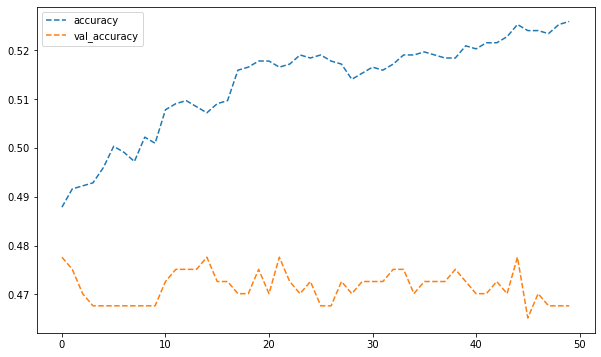

In [39]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [40]:
model.evaluate(training_data_[cols], training_data['direction'])

63/63 [==============================] - 0s 2ms/step - loss: 0.7555 - accuracy: 0.5162


[0.7555052042007446, 0.5161933302879333]

In [41]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

In [48]:
model.predict(training_data_[cols])

array([[0.38421813],
       [0.31614214],
       [0.24959546],
       ...,
       [0.34024355],
       [0.42152166],
       [0.38864818]], dtype=float32)

In [45]:
pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [44]:
len(pred)

2007

In [82]:
pred[:30].flatten()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0])

In [83]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [84]:
training_data['strategy'] = (training_data['prediction'] *
                                      training_data['return'])

In [85]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.826569
strategy    1.338149
dtype: float64

<AxesSubplot:xlabel='Date'>

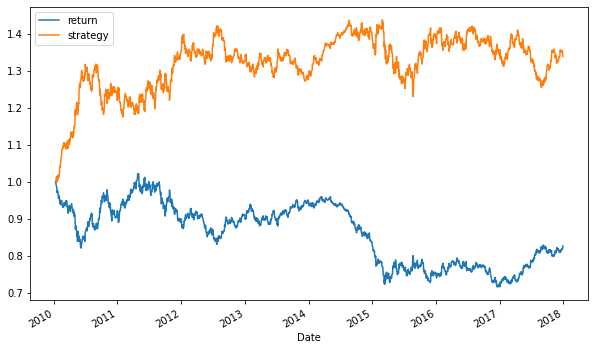

In [86]:
training_data[['return', 'strategy']].cumsum(
                          ).apply(np.exp).plot(figsize=(10, 6))

In [87]:
model.evaluate(test_data_[cols], test_data['direction'])

16/16 [==============================] - 0s 934us/step - loss: 0.7292 - accuracy: 0.5050


[0.7292043566703796, 0.5049701929092407]

In [88]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

In [89]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [90]:
test_data['prediction'].value_counts()

-1    368
 1    135
Name: prediction, dtype: int64

In [91]:
test_data['strategy'] = (test_data['prediction'] *
                                  test_data['return'])

In [92]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.109065
dtype: float64

<AxesSubplot:xlabel='Date'>

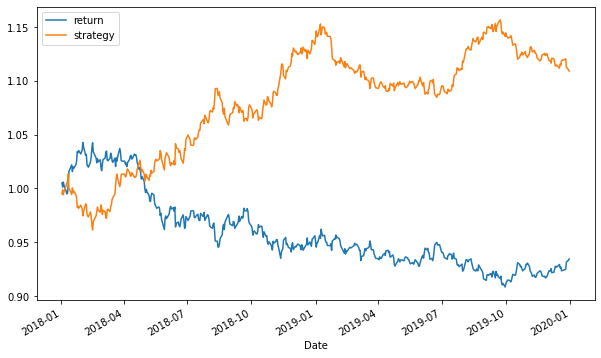

In [93]:
test_data[['return', 'strategy']].cumsum(
                          ).apply(np.exp).plot(figsize=(10, 6))

In [94]:
data['momentum'] = data['return'].rolling(5).mean().shift(1)

In [95]:
data['volatility'] = data['return'].rolling(20).std().shift(1)

In [96]:
data['distance'] = (data['price'] -
                              data['price'].rolling(50).mean()).shift(1)

In [97]:
data.dropna(inplace=True)

In [98]:
cols.extend(['momentum', 'volatility', 'distance'])

In [99]:
print(data.round(4).tail())

             price  return  direction   lag_1   lag_2   lag_3   lag_4   lag_5  \
Date                                                                            
2019-12-24  1.1087  0.0001          1  0.0007 -0.0038  0.0008 -0.0034  0.0006   
2019-12-26  1.1096  0.0008          1  0.0001  0.0007 -0.0038  0.0008 -0.0034   
2019-12-27  1.1175  0.0071          1  0.0008  0.0001  0.0007 -0.0038  0.0008   
2019-12-30  1.1197  0.0020          1  0.0071  0.0008  0.0001  0.0007 -0.0038   
2019-12-31  1.1210  0.0012          1  0.0020  0.0071  0.0008  0.0001  0.0007   

            momentum  volatility  distance  
Date                                        
2019-12-24   -0.0010      0.0024    0.0005  
2019-12-26   -0.0011      0.0024    0.0004  
2019-12-27   -0.0003      0.0024    0.0012  
2019-12-30    0.0010      0.0028    0.0089  
2019-12-31    0.0021      0.0028    0.0110  


In [100]:
training_data = data[data.index < cutoff].copy()

In [101]:
mu, std = training_data.mean(), training_data.std()

In [102]:
training_data_ = (training_data - mu) / std

In [103]:
test_data = data[data.index >= cutoff].copy()

In [104]:
test_data_ = (test_data - mu) / std

In [105]:
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu',
              input_shape=(len(cols),)))  
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])


In [106]:
%%time
model.fit(training_data_[cols], training_data['direction'],
        verbose=False, epochs=25)

Wall time: 1.37 s


In [107]:
model.evaluate(training_data_[cols], training_data['direction'])

62/62 [==============================] - 0s 715us/step - loss: 0.6816 - accuracy: 0.5646


[0.6816269755363464, 0.5646397471427917]

In [108]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

In [109]:
training_data['prediction'] = np.where(pred > 0, 1, -1)


In [110]:
training_data['strategy'] = (training_data['prediction'] *
                                       training_data['return'])

In [111]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.901074
strategy    2.703377
dtype: float64

<AxesSubplot:xlabel='Date'>

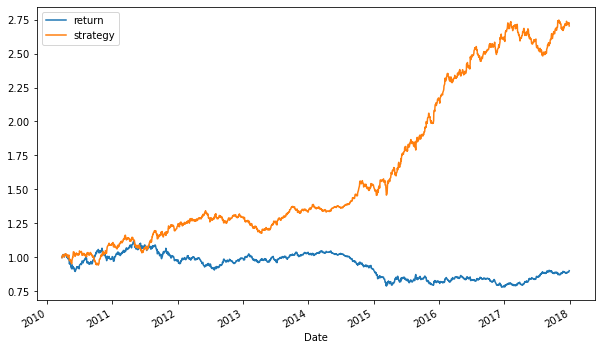

In [112]:
training_data[['return', 'strategy']].cumsum(
                          ).apply(np.exp).plot(figsize=(10, 6))

In [113]:
model.evaluate(test_data_[cols], test_data['direction'])

16/16 [==============================] - 0s 867us/step - loss: 0.6931 - accuracy: 0.5507


[0.6931276321411133, 0.5506958365440369]

In [114]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

In [115]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [116]:
test_data['prediction'].value_counts()

-1    335
 1    168
Name: prediction, dtype: int64

In [117]:
test_data['strategy'] = (test_data['prediction'] *
                                   test_data['return'])

In [118]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.144385
dtype: float64

<AxesSubplot:xlabel='Date'>

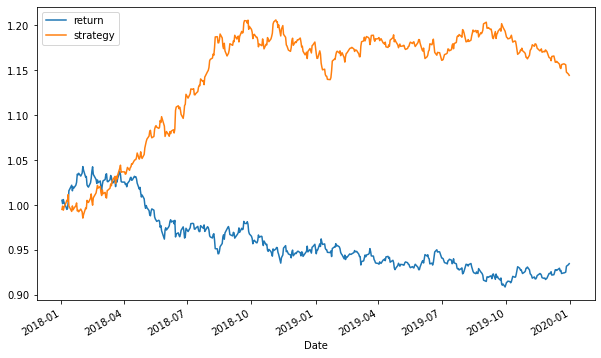

In [119]:
test_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [125]:
test_data.tail(50)

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,prediction,strategy
Date,,,,,,,,,,,,,
2019-10-21,1.1148,-0.001882,0,0.004217,0.004686,0.003529,0.000272,-0.001088,0.002323,0.002954,0.012802,-1,0.001882
2019-10-22,1.1124,-0.002155,0,-0.001882,0.004217,0.004686,0.003529,0.000272,0.002165,0.002930,0.010802,-1,0.002155
2019-10-23,1.1129,0.000449,1,-0.002155,-0.001882,0.004217,0.004686,0.003529,0.001679,0.002966,0.008578,-1,-0.000449
2019-10-24,1.1104,-0.002249,0,0.000449,-0.002155,-0.001882,0.004217,0.004686,0.001063,0.002387,0.009158,-1,0.002249
2019-10-25,1.1078,-0.002344,0,-0.002249,0.000449,-0.002155,-0.001882,0.004217,-0.000324,0.002414,0.006726,1,-0.002344
2019-10-28,1.1098,0.001804,1,-0.002344,-0.002249,0.000449,-0.002155,-0.001882,-0.001636,0.002508,0.004182,-1,-0.001804
2019-10-29,1.1110,0.001081,1,0.001804,-0.002344,-0.002249,0.000449,-0.002155,-0.000899,0.002304,0.006164,-1,-0.001081
2019-10-30,1.1148,0.003415,1,0.001081,0.001804,-0.002344,-0.002249,0.000449,-0.000252,0.002255,0.007296,-1,-0.003415
2019-10-31,1.1150,0.000179,1,0.003415,0.001081,0.001804,-0.002344,-0.002249,0.000341,0.002298,0.010998,-1,-0.000179
